In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torchvision import models
from torch import optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import convolve2d
from PIL import Image
import argparse
import requests
from io import BytesIO
import os
from tqdm.notebook import trange, tqdm
import scipy.ndimage as nd
from torchvision import transforms
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

# Convolution

## Load image

In [2]:
img_path = "https://upload.wikimedia.org/wikipedia/commons/2/26/YellowLabradorLooking_new.jpg"
response = requests.get(img_path)
image    = Image.open(BytesIO(response.content))
image_gray = np.array(image.convert('L'))
image = np.array(image)

## apply convolution

In [3]:
kernel_v = np.array([[-1, 0, +1],
                     [-1, 0, +1],
                     [-1, 0, +1]])
kernel_h = np.array([[-1, -1, -1],
                     [ 0,  0,  0],
                     [+1, +1, +1]])
conv_output_v = convolve2d(image_gray, kernel_v, mode='same')
conv_output_h = convolve2d(image_gray, kernel_h, mode='same')

## display

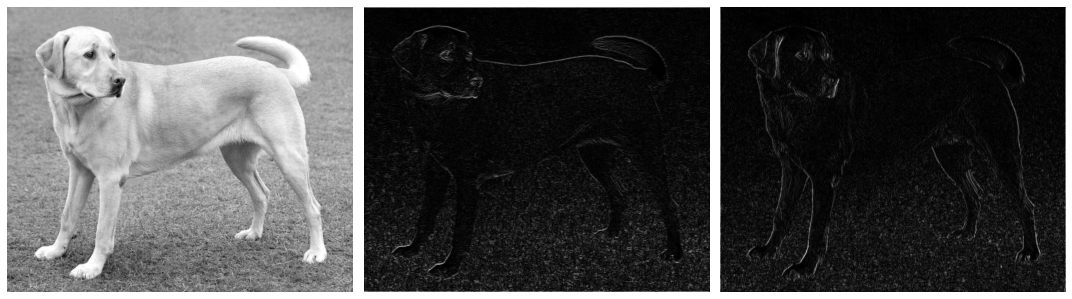

In [4]:
plt.figure(figsize=(15,5))
plt.subplot(131), plt.imshow(image_gray, cmap='gray'), plt.axis('off')
plt.subplot(132), plt.imshow(np.abs(conv_output_h), cmap='gray'), plt.axis('off')
plt.subplot(133), plt.imshow(np.abs(conv_output_v), cmap='gray'), plt.axis('off')
plt.tight_layout()
plt.show()

# CNN

## data

In [5]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [6]:
batch_size = 4
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
# get images/labels set
train_set = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_set = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
# create loader
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size,  shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


## model

In [7]:
class My_CNN_model(nn.Module):
    
    def __init__(self):
        '''define some layers'''
        super().__init__()
        # feature learning
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool  = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        # classification
        self.fc1 = nn.Linear(16*5*5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        '''create model architecture'''
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten before classification
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [8]:
my_cnn_model = My_CNN_model()

## training

In [9]:
my_cnn_model = my_cnn_model.cuda()

In [10]:
# define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(my_cnn_model.parameters(), lr=0.001, momentum=0.9)
# training loop
num_epochs = 5
for epoch in trange(num_epochs, desc="epoch loop"):
    for i, data in enumerate(tqdm(train_loader, desc="batch loop", leave=False)):
        images, labels = data
        images, labels = images.cuda(), labels.cuda()
        # Forward pass
        outputs = my_cnn_model(images)
        loss = criterion(outputs, labels)
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        # optimization step
        optimizer.step()

# Deep Dream

## Processing

In [11]:
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
preprocess = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean, std)])

In [12]:
def deprocess(image_np):
    image_np = image_np.squeeze().transpose(1, 2, 0)
    image_np = image_np * std.reshape((1, 1, 3)) + mean.reshape((1, 1, 3))
    image_np = np.clip(image_np, 0, 1)
    return image_np

def clip(image_tensor):
    for c in range(3):
        m, s = mean[c], std[c]
        image_tensor[0, c] = torch.clamp(image_tensor[0, c], -m/s, (1 - m)/s)
    return image_tensor

## Load CNN model

In [15]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model_name = 'vgg19'
if model_name == 'vgg19':
    network = models.vgg19(pretrained=True)
if model_name == 'inception':
    network = models.inception_v3(pretrained=True)    

## Algorithm

In [16]:
# Parameters
iterations   = 25   # number of gradient ascent steps per octave
at_layer     = 26   # layer at which we modify image to maximize outputs
lr           = 0.01 # learning rate
octave_scale = 2    # image scale between octaves
num_octaves  = 4    # number of octaves

In [17]:
layers = list(network.features.children())
model = nn.Sequential(*layers[: (at_layer + 1)])
model = model.to(device)

The loss is the sum of the activations in the chosen layers. The loss is normalized at each layer so the contribution from larger layers does not outweigh smaller layers. Normally, loss is a quantity you wish to minimize via gradient descent. In DeepDream, you will maximize this loss via gradient ascent.

In [18]:
def deep_dream(image, save=False):
    # Extract image representations for each octave
    octaves = [image]
    for _ in range(num_octaves - 1):
        image_scaled = nd.zoom(octaves[-1], (1, 1, 1/octave_scale, 1/octave_scale), order=1)
        octaves.append(image_scaled)   
    # loop on different resolution scale
    detail = np.zeros_like(octaves[-1])
    for k, octave_base in enumerate(tqdm(octaves[::-1], desc="Octaves : ")):
        # Upsample detail to new octave dimension
        if k > 0: detail = nd.zoom(detail, np.array(octave_base.shape)/np.array(detail.shape), order=1) 
        # Add detail from previous octave to new base
        input_image = octave_base + detail
        # Updates the image to maximize outputs for n iterations
        input_image = Variable(torch.FloatTensor(input_image).to(device), requires_grad=True)
        for i in trange(iterations, desc="Iterations : ", leave=False):
            model.zero_grad()
            out  = model(input_image)
            loss = out.norm() #out[0][0] 
            loss.backward()
            # gradient ascent
            avg_grad = np.abs(input_image.grad.data.cpu().numpy()).mean()
            norm_lr  = lr/avg_grad
            input_image.data = input_image.data + norm_lr * input_image.grad.data
            input_image.data = clip(input_image.data)
            input_image.grad.data.zero_()
            # Extract deep dream details
            detail = input_image.cpu().data.numpy() - octave_base
            # save
            if save:
                detail = nd.zoom(detail, np.array(octaves[0].shape)/np.array(detail.shape), order=1) 
                dreamed_image = (octaves[0] + detail)
                dreamed_image = deprocess(dreamed_image)
                plt.imsave('dream_layer{:2d}_{:2d}.png'.format(at_layer, i+k*iterations), dreamed_image)
    dreamed_image = deprocess(input_image.cpu().data.numpy())
    return dreamed_image

### on dog

In [19]:
image_p = preprocess(image).unsqueeze(0).cpu().data.numpy()
dreamed_image = deep_dream(image_p)

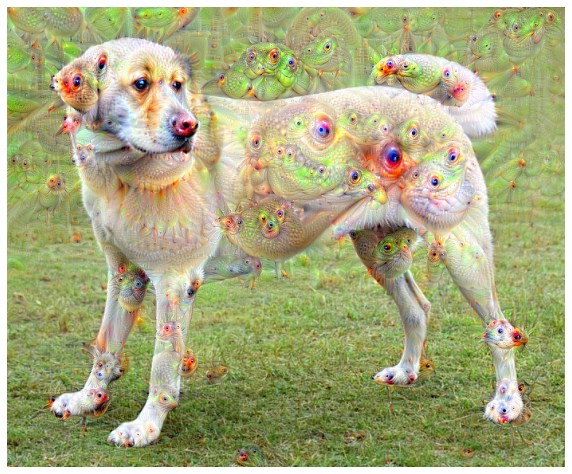

In [20]:
# display
plt.figure(figsize=(10, 10))
plt.imshow(dreamed_image)
plt.axis('off')
plt.show()

### on random noise

In [21]:
image = np.random.rand(300,300,3)
image_p = preprocess(image).unsqueeze(0).cpu().data.numpy()
dreamed_image = deep_dream(image_p)

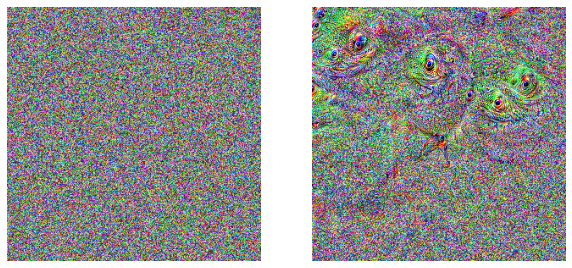

In [22]:
# display
plt.figure(figsize=(10, 10))
plt.subplot(121), plt.imshow(image), plt.axis('off')
plt.subplot(122), plt.imshow(dreamed_image), plt.axis('off')
plt.show()

In [ ]:
# load librairies
from lucent.optvis import render
from lucent.modelzoo import vgg19
# load model
model = vgg19(pretrained=True)
model = model.to(device)
model.eval()
# run optimisation
image = render.render_vis(model, "features:30",thresholds=[100],show_inline=True)

100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:20<00:00,  1.93it/s]



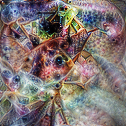

100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:22<00:00,  1.81it/s]



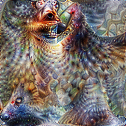

100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:22<00:00,  1.75it/s]



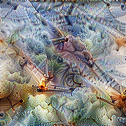

100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:23<00:00,  1.72it/s]



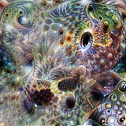

In [14]:
image = render.render_vis(model, "features:30",thresholds=[100],show_inline=True)